# **DSC 190 – Statistical Analysis Notebook**

**Research Question 1**

> Is there a relationship between **location on campus (Zone)** and the **type of incident** reported?

**Research Question 2**

> Is there a statistically significant difference in the **number and type of incidents** across  
> (a) **day of week** and (b) **time of day** (late night vs early morning, etc.)?

This notebook focuses only on exploratory analysis.

## 1. Setup: mount drive, imports, load messy data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# df = pd.read_csv("data/police_logs_parsed_EXACT.csv")

# df.head()
# df.info()

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/DSC 190 Project/Cleaned CSV/police_logs_parsed_EXACT.csv"
df = pd.read_csv(file_path)

df.head()
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Incident type   2456 non-null   object
 1   Location        2456 non-null   object
 2   Date Reported   2456 non-null   object
 3   Incident/Case#  2456 non-null   object
 4   Date Occurred   2456 non-null   object
 5   Time Occurred   2456 non-null   object
 6   Summary         1211 non-null   object
 7   Disposition     2456 non-null   object
dtypes: object(8)
memory usage: 153.6+ KB


In [18]:
df

,Incident type,Location,Date Reported,Incident/Case#,Date Occurred,Time Occurred,Summary,Disposition
0,Suspicious Person,"One Miramar Street, Building 2",8/10/2025,2508100004,8/10/2025,4:30 AM,Subject possibly carrying a folded cardboard box,Unable to Locate
1,Incomplete/Accidental Wireless 911,Tioga Hall,8/10/2025,2508100006,8/10/2025,7:17 AM,NaN,Logged Event
2,Elevator Problem,South Parking Structure,8/10/2025,2508100007,8/10/2025,8:35 AM,Person stuck inside southwest elevator,Referred to Other Department (UCSD)
3,Animal Call,SIO Pier,8/10/2025,2508100008,8/10/2025,8:47 AM,People touching leopard sharks,Referred to Other Agency
4,Fire Alarm,Tamarack Apartments,8/10/2025,2508100010,8/10/2025,10:31 AM,NaN,False Alarm
...,...,...,...,...,...,...,...,...
2451,Medical Aid,Lifeguard Tower,9/9/2025,2509090041,9/9/2025,6:58 PM,NaN,Referred to Other Agency
2452,Vehicle Impound,9400 South Medical Center Drive,9/9/2025,2025-1524,9/9/2025,9:32 PM,NaN,Vehicle Towed
2453,Found Property,Israni Biomedical Research Facility,9/9/2025,2025-1525,9/9/2025,9:49 PM - 10:41 PM,Backpack,Report Taken
2454,Attempt to Contact,Capa,9/9/2025,2509090052,9/9/2025,10:40 PM,Roommate who has not been answering phone,Service Provided


In [19]:
len(df)

2456

##2. Cleaning the data
-Copied raw dataset to avoid modifying the original (df2 = df.copy()).

- Created keyword lists for each college zone based on common building names, dorms, landmarks, acronyms, and misspellings.

- Searched the Location column for any of these keywords (case-insensitive).

- Assigned a zone by mapping each location to the college whose keywords it matched.

- Defaulted non-matching locations to “Off Campus”.


In [20]:
df2 = df.copy()

In [21]:
# Define keyword rules
college_keywords = {
    "Revelle": ["tata","roger's","pacific","natural science","meteor","mayer","galathea","che", "revelle", "galbraith", "york", "nat sci", "urey","64", "argo", "atlantis", "blake", "bonner", "beagle hall", "charles david"],
    "Muir": ["tuolumne","tenaya","stewart","pines","mcgill","mandler","humanities and social sciences","muir", "wilderness", "muir college", "tioga", "tamarack", "biology"],
    "Marshall": ["alianza","justice","peace","unity","social sciences","revolutionary","malk","liberation","oceanview","human rights","grassroots","goody","malk hall","umoja","marshall", "governor", "scholar", "t-hall", "alianza", "coalition"],
    "Warren": ["harlan","goldberg","frankfurt","engineering","warren", "bioengineering", "jacobs", "ebui", "mae", "antonio", "atkinson hall", "brennan", "brown", "bates", "canyon vista", "computer science","douglas", "discovery"],
    "ERC": ["north america","latin america","geneva","great","europe","erc","asante","roosevelt", "international", "africa ", "asia", "ventana", "cuzco", "earth"],
    "Sixth": ["jeannine","tapestry","survivance","surviance","kaleidoscope","sixth", "pepper canyon", "design & innovation", "catalyst","cognitive", "communication"],
    "Seventh": ["bistro","otterson","seventh", "nuevo east", "nuevo west"],
    "Eighth": ["podemos","pulse","theater","dance","eighth", "north torrey", "pangea", "azad"],
    "Med": ["va", "health station","hospital", "medical", "thornton", "shiley", "cancer", "sulpizio", "perlmutter"],
    "Main": ["central campus station","parking","uc san diego", "ucsd","arena"," central hall","jacaranda","jeannie","rya ", " rya","student services", "tec","sunshine", "tapioca express","target","the trove","triton center", "triton", "taco", "tahini", "sun god","starbucks","student health","shake","avery","skaggs","shores", "school of medicine","wongavery","matthew","mandeville","main gym","liontree","lion tree","palade","foodworx","epstein","dirty","design","music center","center for neural","central campus trolley station","central hall ", "career services center","cellular molecular medicine east","cellular and molecular medicine", "yogurt world", "women","cellular & molecular", "center all", "central hall" "arena","alumni","rimac","center hall", "rita","geisel", "student center", "pc", "price center", "library walk", "target" "rya","vela", "bookstore", "bike shop", "canyonview", "aquatic"],
}


In [22]:
df2[df2['Location'].str.contains('trolley', case=False, na=False)]

,Incident type,Location,Date Reported,Incident/Case#,Date Occurred,Time Occurred,Summary,Disposition
10,Incomplete/Accidental Wireless 911,Trolley - La Jolla Health Station,8/10/2025,2508100026,8/10/2025,5:43 PM,NaN,Logged Event
11,Incomplete/Accidental Landline 911,Trolley - La Jolla Health Station,8/10/2025,2508100027,8/10/2025,5:45 PM,NaN,Logged Event
15,Suspicious Person,Trolley - Central Campus Station,8/10/2025,2508100041,8/10/2025,9:49 PM,MTS Security requesting assistance with subjec...,Field Interview
87,Assist Other Agency,Trolley - VA Medical Center,8/14/2025,2508140012,8/14/2025,6:13 AM,VAPD requesting unit with fingerprint scanner,Service Provided
149,Citizen Contact,Trolley - Central Campus,8/17/2025,2508170033,8/17/2025,8:55 PM,NaN,Service Provided
183,Outside Warrant- Felony,Trolley - Central Campus Station,8/19/2025,2025-1431,8/19/2025,6:26 PM,Subject contacted for fare evasion was arreste...,Closed By Adult Arrest
247,"Disturbance, Psych Patient",Trolley- VA Medical Hospital,8/22/2025,2508220044,8/22/2025,4:01 PM,Male subject acting erratically,Unable To Locate
255,Welfare Check,Trolley- La Jolla Health Station,8/22/2025,2508220064,8/22/2025,11:14 PM,Male locked inside restroom refusing to leave,Checks Ok
294,Suspicious Vehicle,Trolley - La Jolla Health Station,8/24/2025,2508240038,8/24/2025,9:31 PM,Dog locked in vehicle,Checks OK
295,Illegal Camping,Trolley - La Jolla Health Station,8/24/2025,2508240040,8/24/2025,9:36 PM,NaN,Referred to Other Agency


In [23]:
def assign_zone(location):
    loc_lower = str(location).lower()
    for college, keywords in college_keywords.items():
        if any(word in loc_lower for word in keywords):
            return college
    return "Off Campus" # default if nothing matches

df2["Zone"] = df2["Location"].apply(assign_zone)


In [24]:
df2.to_csv("df2.csv", index=False)
from google.colab import files
files.download("df2.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
df

,Incident type,Location,Date Reported,Incident/Case#,Date Occurred,Time Occurred,Summary,Disposition
0,Suspicious Person,"One Miramar Street, Building 2",8/10/2025,2508100004,8/10/2025,4:30 AM,Subject possibly carrying a folded cardboard box,Unable to Locate
1,Incomplete/Accidental Wireless 911,Tioga Hall,8/10/2025,2508100006,8/10/2025,7:17 AM,NaN,Logged Event
2,Elevator Problem,South Parking Structure,8/10/2025,2508100007,8/10/2025,8:35 AM,Person stuck inside southwest elevator,Referred to Other Department (UCSD)
3,Animal Call,SIO Pier,8/10/2025,2508100008,8/10/2025,8:47 AM,People touching leopard sharks,Referred to Other Agency
4,Fire Alarm,Tamarack Apartments,8/10/2025,2508100010,8/10/2025,10:31 AM,NaN,False Alarm
...,...,...,...,...,...,...,...,...
2451,Medical Aid,Lifeguard Tower,9/9/2025,2509090041,9/9/2025,6:58 PM,NaN,Referred to Other Agency
2452,Vehicle Impound,9400 South Medical Center Drive,9/9/2025,2025-1524,9/9/2025,9:32 PM,NaN,Vehicle Towed
2453,Found Property,Israni Biomedical Research Facility,9/9/2025,2025-1525,9/9/2025,9:49 PM - 10:41 PM,Backpack,Report Taken
2454,Attempt to Contact,Capa,9/9/2025,2509090052,9/9/2025,10:40 PM,Roommate who has not been answering phone,Service Provided


##3. Manual Cleaning
Why Manual Cleaning Was Important

- Inconsistent spellings (e.g., Center Hall, Central Hall, Centrl Hall) meant the same place appeared as multiple distinct locations. Manual cleaning ensured all variations mapped to the same standardized location.

- Many incidents listed informal or partial names, slang, abbreviations, or misspellings that automated rules alone couldn’t reliably interpret.

- Some locations referenced building nicknames or nearby landmarks, which required human judgment to map to the correct college zone.

- Manual review allowed us to validate and correct misclassified locations, ensuring accuracy before running spatial analyses.

- By standardizing location names and zones manually, we ensured consistent, trustworthy data, making downstream visualizations and statistical comparisons meaningful.

In [26]:
file_path = "/content/drive/MyDrive/DSC 190 Project/Cleaned CSV/df_clean_zones.csv"
df_clean = pd.read_csv(file_path)

df_clean.head()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Incident type   2456 non-null   object
 1   Location        2456 non-null   object
 2   Date Reported   2456 non-null   object
 3   Incident/Case#  2456 non-null   object
 4   Date Occurred   2456 non-null   object
 5   Time Occurred   2455 non-null   object
 6   Summary         1211 non-null   object
 7   Disposition     2456 non-null   object
 8   Zone            2456 non-null   object
dtypes: object(9)
memory usage: 172.8+ KB


##4. Exploratory Analysis

- filter out **Off Campus**
- create multiple graphs to explore our data

In [27]:
filtered = df_clean[df_clean['Zone'] != 'Off Campus']

filtered.head()

,Incident type,Location,Date Reported,Incident/Case#,Date Occurred,Time Occurred,Summary,Disposition,Zone
2,Petty Theft - Mirco Mobility Device,Center Hall,10/2/2025,2510020077,10/2/2025,10:02 PM,Secured Electric Scooter Stolen; Loss $350,Report Taken,Main
3,Alcohol Contact,The Market,8/16/2025,2508160044,8/16/2025,10:02 PM,NaN,Will Cooperate,Seventh
4,Alcohol Contact,Goldberg Apartments,10/3/2025,2510030095,10/3/2025,11:50 PM,People in apartment who are intoxicated with a...,Checks OK,Warren
8,Animal Call,Urey Hall,8/21/2025,2508210047,8/21/2025,5:05 PM,Loose Golden Retriever in the area,Unbale To Locate,Revelle
9,Animal Call,Cognitive Science Building,9/24/2025,2509240045,9/24/2025,2:24 PM,2 small dogs have been tied to a bench for 45 ...,Service Provided,Sixth


###Plot: Top 10 Most Common Incident Types

This graph displays the ten most frequently reported incident types, allowing us to quickly see which issues occur most often on campus. By visualizing the counts, it highlights patterns in campus safety concerns and helps identify the categories that dominate the dataset.

/tmp/ipython-input-1890170071.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['incident type'] = filtered['incident type'].str.lower()


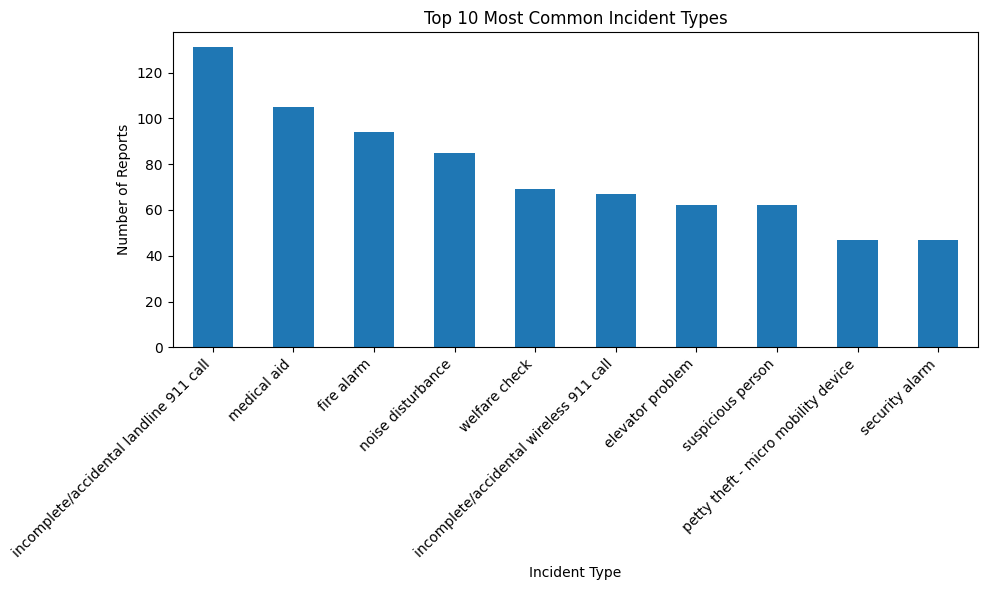

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

filtered.columns = df_clean.columns.str.strip().str.lower()

filtered['incident type'] = filtered['incident type'].str.lower()

incident_counts = filtered['incident type'].value_counts()

incident_counts.head(10).plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Most Common Incident Types')
plt.xlabel('Incident Type')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


###Plot: Number of Incidences by Day of Week
This graph shows how incident frequency varies across the days of the week, making it easy to spot which days tend to have the most reported events. By ordering the days Monday through Sunday, the plot highlights weekly patterns in campus activity and helps identify when incidents are most likely to occur.

Most common day of week:
day_of_week
Friday    252
Name: count, dtype: int64


/tmp/ipython-input-565514640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['date occurred'] = pd.to_datetime(filtered['date occurred'], errors='coerce')


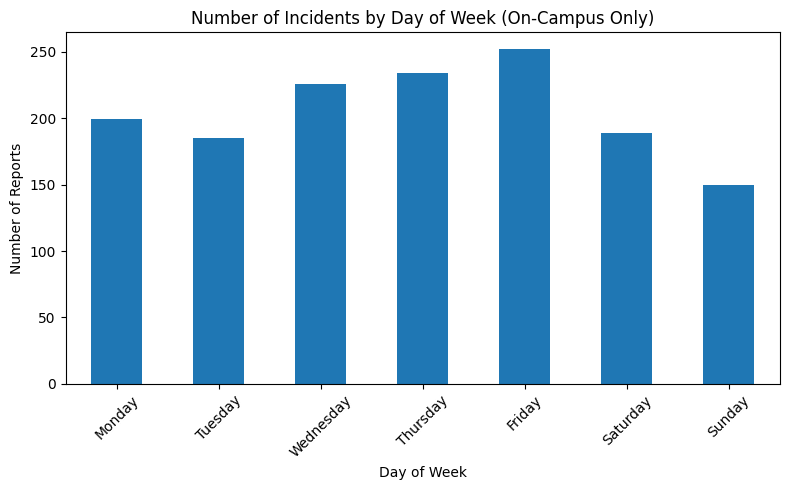

In [29]:
filtered['date occurred'] = pd.to_datetime(filtered['date occurred'], errors='coerce')

# Drop missing dates
filtered = filtered.dropna(subset=['date occurred'])

# Extract day of week
filtered['day_of_week'] = filtered['date occurred'].dt.day_name()

# Find most common day
most_common_day = filtered['day_of_week'].value_counts().head(1)
print("Most common day of week:")
print(most_common_day)

# Plot incidents by day
filtered['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).plot(kind='bar', figsize=(8,5))

plt.title('Number of Incidents by Day of Week (On-Campus Only)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Plot: Number of Incidents by Hour of Day
This plot displays how incidents are distributed across the 24-hour day, making it clear which hours experience the highest activity. By converting times into numeric hours and counting their frequencies, the graph reveals daily patterns—such as spikes during late evenings or early afternoons—that help explain when incidents are most likely to occur.

/tmp/ipython-input-2945103783.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered['hour'] = pd.to_datetime(filtered['time occurred'].astype(str)).dt.hour


Most common hour of day: 22:00


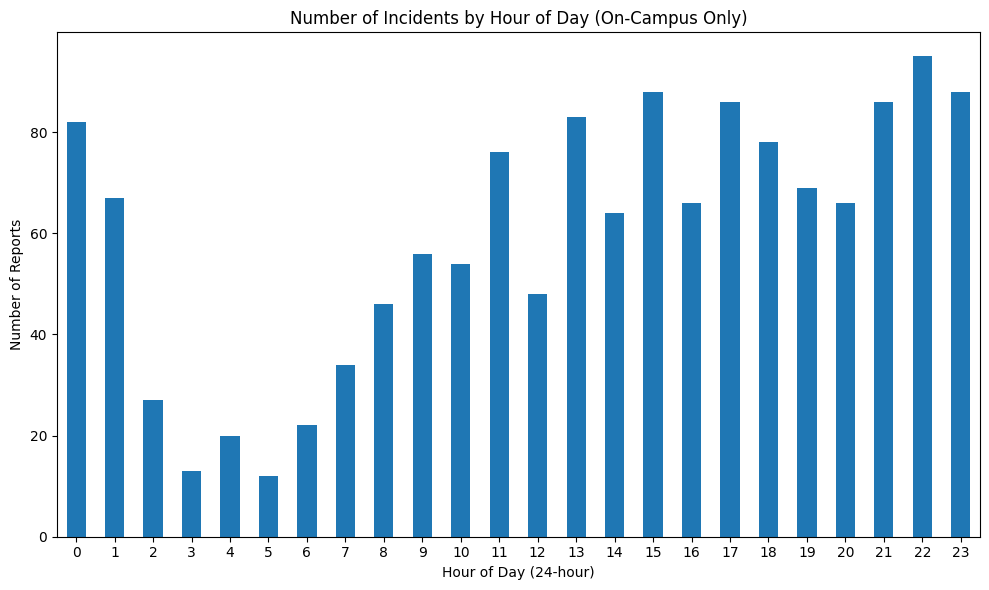

In [30]:
filtered['time occurred'] = pd.to_datetime(
    filtered['time occurred'], format='%I:%M %p', errors='coerce'
).dt.time

# Drop missing times
filtered = filtered.dropna(subset=['time occurred'])

# Extract hour (0–23)
filtered['hour'] = pd.to_datetime(filtered['time occurred'].astype(str)).dt.hour

# Most common hour
most_common_hour = filtered['hour'].value_counts().idxmax()
print(f"Most common hour of day: {most_common_hour}:00")

# Plot number of incidents by hour
filtered['hour'].value_counts().sort_index().plot(kind='bar', figsize=(10,6))

plt.title('Number of Incidents by Hour of Day (On-Campus Only)')
plt.xlabel('Hour of Day (24-hour)')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

###Plot: Number of Incidents by Zone
This bar chart shows how incidents are distributed across campus zones, helping identify which areas experience the most activity. By counting reports within each zone, the graph highlights clear hotspots on campus and reveals where incidents are most concentrated.

Zone with the most incidents: Main


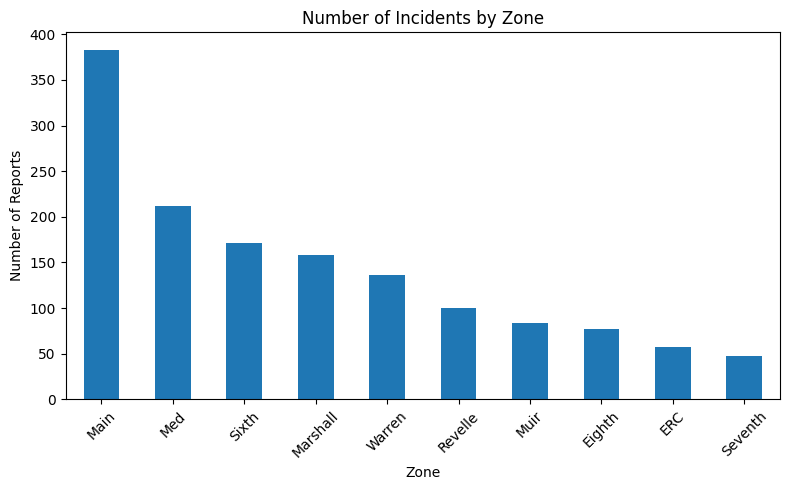

In [31]:
zone_counts = filtered['zone'].value_counts()
most_common_zone = zone_counts.idxmax()
print(f"Zone with the most incidents: {most_common_zone}")

# Plot the counts
zone_counts.plot(kind='bar', figsize=(8,5))
plt.title('Number of Incidents by Zone')
plt.xlabel('Zone')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()